In [6]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import arviz as az

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

import logging

from datetime import date
import os

from tqdm import tqdm

In [ ]:
def forward(x, a, b):
    u = (x - a)/(b-a)
    return np.log(u / (1 - u))

def backward(y, a, b):
    return a + (b-a)/(1 + np.exp(-y))

Text(0.5, 1.0, '$\\log \\frac{\\frac{X-a}{b-a}}{1 - \\frac{X-a}{b-a}}$')

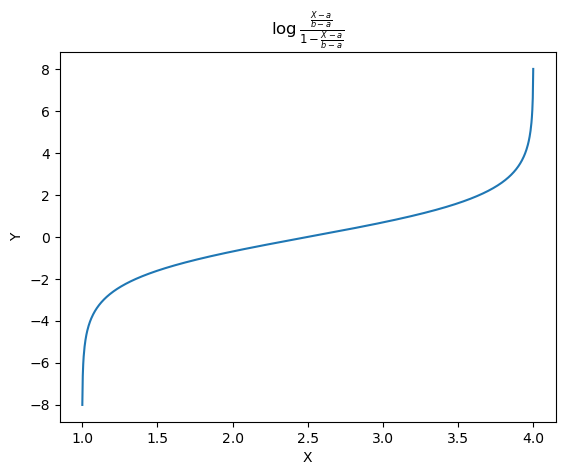

In [ ]:
x = np.linspace(1.001, 3.999, 1000)
plt.plot(x, forward(x, 1., 4.))
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'$\log \frac{\frac{X-a}{b-a}}{1 - \frac{X-a}{b-a}}$')

Text(0.5, 1.0, '$a + \\frac{b-a}{1+e^{-y}}$')

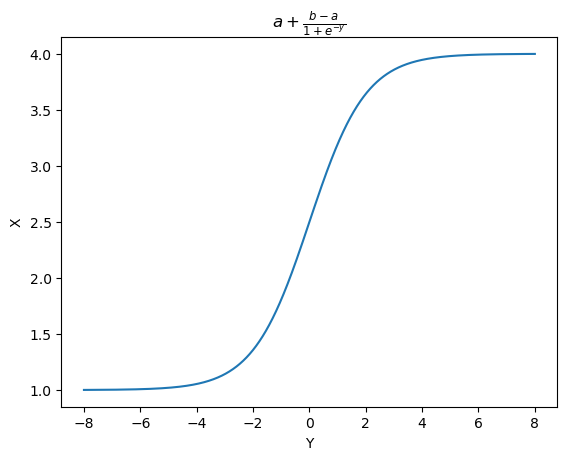

In [ ]:
x = np.linspace(-8, 8, 100000)
plt.plot(x, 1. + 3./(1+np.exp(-x)))
plt.xlabel('Y')
plt.ylabel('X')
plt.title(r'$a + \frac{b-a}{1+e^{-y}}$')

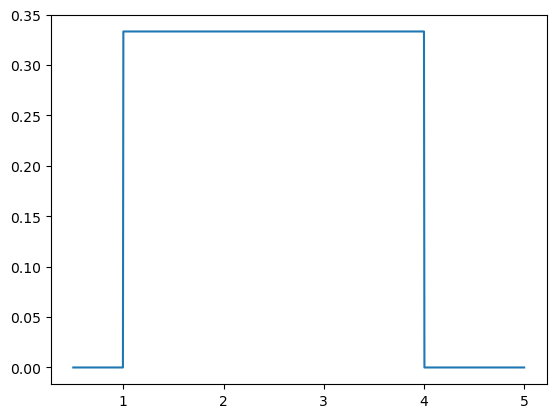

In [ ]:
x = np.linspace(0.5, 5, 1000)

pdf = prior['rt_0']['dist'](
                loc=prior['rt_0']['lower'],
                scale=(prior['rt_0']['upper'] - prior['rt_0']['lower'])
            ).pdf(x)

plt.plot(x, pdf)

## Simulate Data

In [3]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

In [4]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

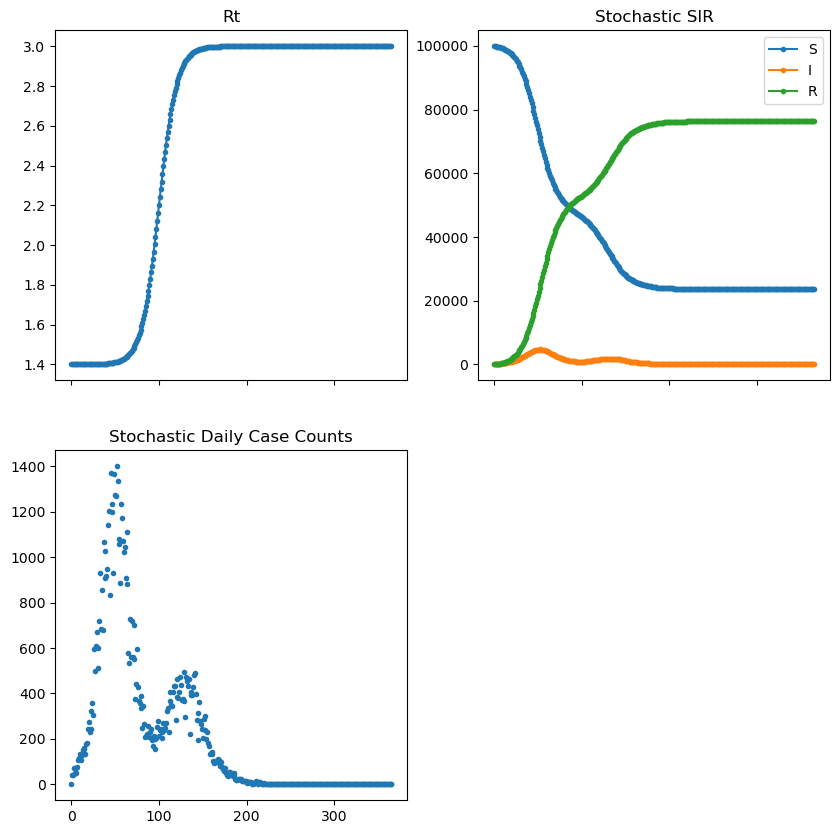

In [ ]:
data.plot_all()

## Metropolis Hastings

0. Initialize $\theta_0 \sim p(\theta)$
1. For each iteration `t=0:num_burn_in+num_draws`
    * Generate candidate $\theta^\prime \sim \mathcal{N}(\theta_t, \sigma=2)$ **fixed step size**
    * Acceptance ratio $r = \min\left(1, \frac{p(\theta^\prime)p(x|\theta^\prime)}{p(\theta_t)p(x|\theta_t)}\right) $
        - Equivalently in log space
         $
         \log(r) = \min\left(0, \log p(\theta^\prime) + \log p(x|\theta^\prime) - \log p(\theta_t) - \log p(x|\theta_t)\right)
         $
    * Accept/ reject
        - $u \sim U[0,1]$
        - If $\log(u) \leq \log(r)$, then *accept*, i.e., $\theta_{t+1} = \theta^\prime$
        - Otherwise $\log(u) > \log(r)$, then *reject*, i.e., $\theta_{t+1} = \theta_{t}$

In [ ]:
## unset seed
np.random.seed()

In [ ]:
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson
from scipy.stats import multivariate_normal
from scipy.stats import norm

In [ ]:
import model_metropolis_hastings
importlib.reload(model_metropolis_hastings)

sir_model = model_metropolis_hastings.SIR_model(data)

likelihood = {
    'dist': 'normal',
}
prior = {
    'rt_0':{
        'dist': uniform,
        'lower': 1.,
        'upper': 4.,
    },
    'rt_1':{
        'dist': uniform,
        'lower': 1.5,
        'upper': 4.,
    },
    'k':{
        # 'dist': uniform,
        'dist': "constant",
        'lower': 0.01,
        'upper': 2,
    },
    'midpoint':{
        # 'dist': randint,
        'dist': "constant",
        'lower': 30,
        'upper': 200,
    },
    'I0':{
        # 'dist': poisson,
        'dist': "constant",
        'mu': 50,
    },
}

n_samples = 50000
n_tune = 10000
tune_interval = 100

params = []
for k,v in prior.items():
    if v['dist'] != "constant":
        params.append(k)

today = date.today() 
name = f"custom_MH_likelihood_{likelihood['dist']}_grid_search"
path = os.path.abspath(f'../data/{today}_{name}')

print(name)

custom_MH_likelihood_normal_grid_search


### Metropolis-Hastings

In [139]:
import model_metropolis_hastings
importlib.reload(model_metropolis_hastings)

from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import poisson


sir_model = model_metropolis_hastings.SIR_model(data)

prior = {
    'rt_0':{
        'dist': uniform,
        'args':{
        'lower': 1.,
        'upper': 4.,
        }
    },
    'rt_1':{
        'dist': uniform,
        'args': {
            'lower': 1.5,
            'upper': 4.,
        }
    },
    'k':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['k'],
        # }
        'dist': uniform,
        'args': {
            'lower': 0.01,
            'upper': 2,
        }
    },
    'midpoint':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['midpoint'],
        # }
        'dist': randint,
        'args': {
            'lower': 30,
            'upper': 200,
        }
    },
    'I0':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['I0'],
        # }
        'dist': poisson,
        'args': {
            'mu': 50,
        }
    },
}

n_samples = 50000
n_tune = 10000
tune_interval = 100


today = date.today() 
name = f"{method}_custom_MH_likelihood_normal"
path = os.path.abspath(f'../data/{today}_{name}')

print(name)

NUTS_custom_MH_likelihood_normal


In [140]:
sir_model.run_SIR_model(n_samples, n_tune, tune_interval, prior, path)

100%|█████████████████████████████████████████████| 60000/60000 [1:53:41<00:00,  8.80it/s]


                mean      HDI 3%     HDI 94%  truth
k           0.819035    0.819035    0.819035    0.1
midpoint  140.000000  140.000000  140.000000  100.0
rt_1        3.057529    3.057529    3.057529    3.0
rt_0        2.800385    2.800385    2.800385    1.4
I0          0.000000    0.000000    0.000000  100.0
[0.06633333 0.06668333 0.0652     0.06488333 0.06585   ]


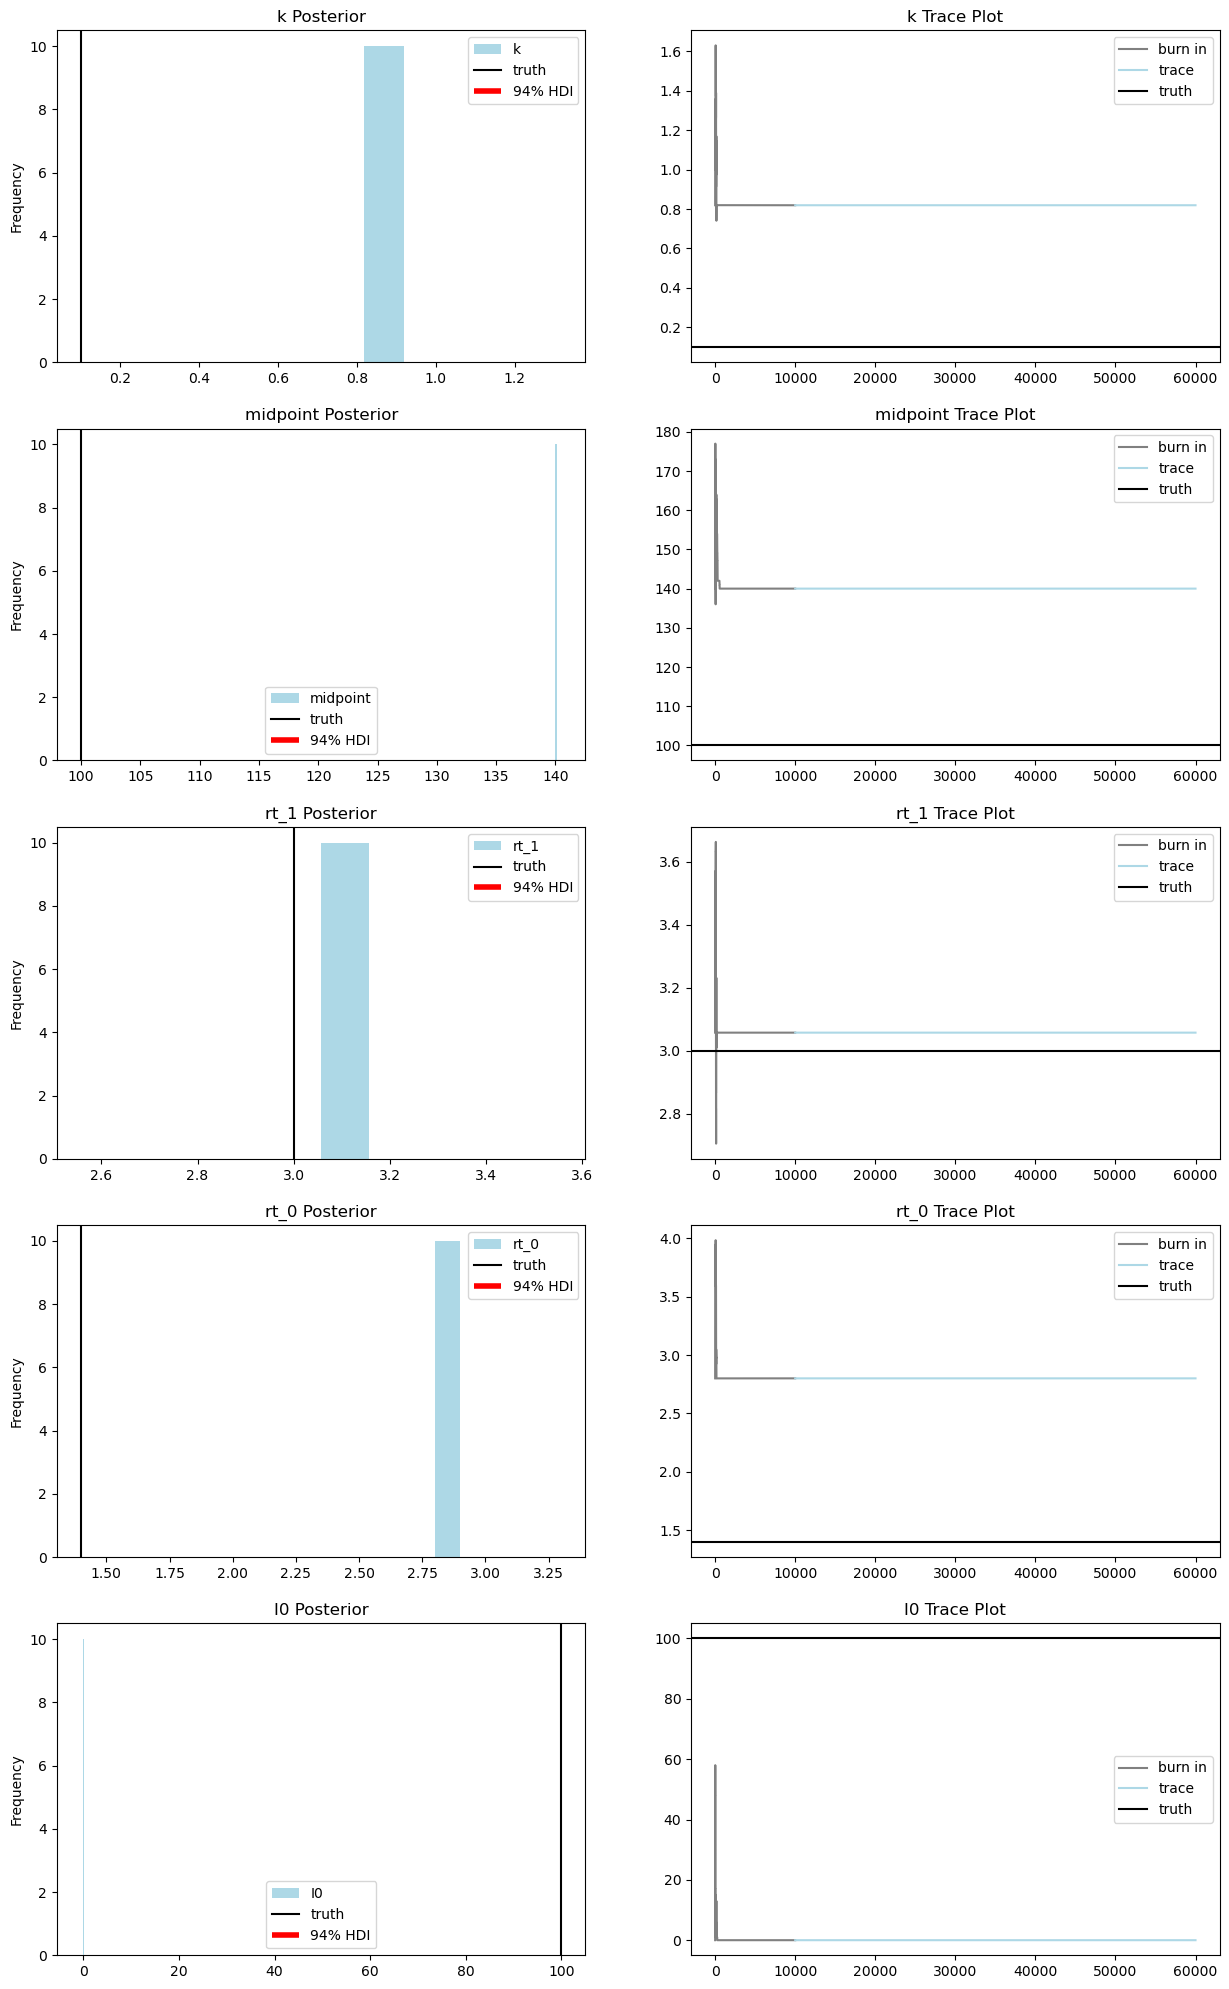

In [142]:
sir_model.plot_trace()

Effective Sample Size
$$
\hat{N}_{\mathrm{eff}}=\frac{M \cdot N}{\hat{\tau}}
$$
where
$$
\hat{\tau}=1+2 \sum_{t=1}^{2 m+1} \hat{\rho}_t=-1+2 \sum_{t^{\prime}=0}^m \hat{P}_{t^{\prime}}
$$
$$
\hat{P}_{t^{\prime}}=\hat{\rho}_{2 t^{\prime}}+\hat{\rho}_{2 t^{\prime}+1}
$$
$$
\hat{\rho}_t=1-\frac{W-\frac{1}{M} \sum_{m=1}^M \hat{\rho}_{t, m}}{\widehat{\mathrm{var}}^{+}}
$$

In [143]:
print(f'rt_0 ess: {az.ess(sir_model.trace.rt_0.values)}')
print(f'rt_1 ess: {az.ess(sir_model.trace.rt_1.values)}')

rt_0 ess: 50000
rt_1 ess: 50000


<AxesSubplot: title={'center': 'x\n0'}>

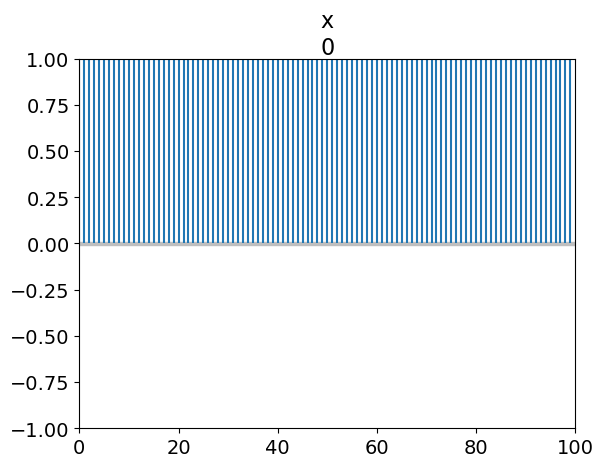

In [144]:
az.plot_autocorr(sir_model.trace.rt_0.values)

In [129]:
ess_list = []
for i in tqdm(range(2,len(sir_model.trace))):
    ess_list.append(az.ess(sir_model.trace.rt_0.iloc[:i].values))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:27<00:00, 178.61it/s]


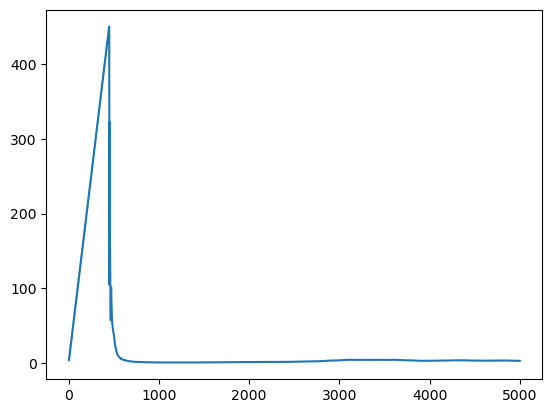

In [130]:
plt.plot(ess_list)

<AxesSubplot: >

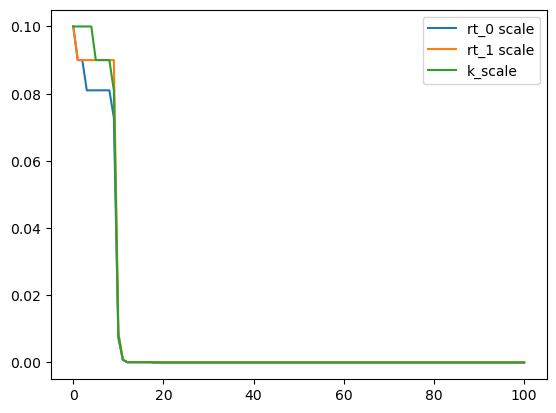

In [145]:
scale_df = pd.DataFrame(sir_model.scale_list, columns=['rt_0 scale', 'rt_1 scale', 'k_scale', 'midpoint_scale', 'I0_scale'])
scale_df[['rt_0 scale', 'rt_1 scale', 'k_scale']].plot()

<AxesSubplot: >

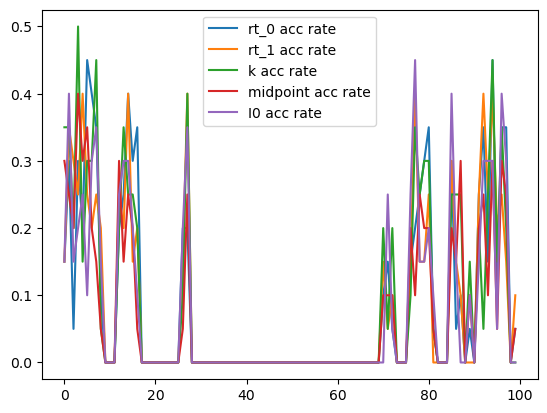

In [146]:
acc_df = pd.DataFrame(sir_model.acc_rate_list, columns=['rt_0 acc rate', 'rt_1 acc rate', 'k acc rate', 'midpoint acc rate', 'I0 acc rate'])
acc_df.plot()

In [147]:
np.mean(sir_model.burn_in['rt_0'].iloc[0:19].values == sir_model.burn_in['rt_0'].iloc[1:20].values)

0.8421052631578947

In [148]:
scale_df.shape

(101, 5)

Percent of observations in 95% CI 38.9%
Percent of observations in 50% CI 17.26%


/opt/anaconda3/envs/rt-estimation/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/hwunrow/Documents/GitHub/rt-estimation/src/model_metropolis_hastings.py:499: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  def calc_ppc_data(self):
/Users/hwunrow/Documents/GitHub/rt-estimation/src/model_metropolis_hastings.py:500: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ci_95 = az.hdi(self.i_ppc, hdi_prob=0.95)


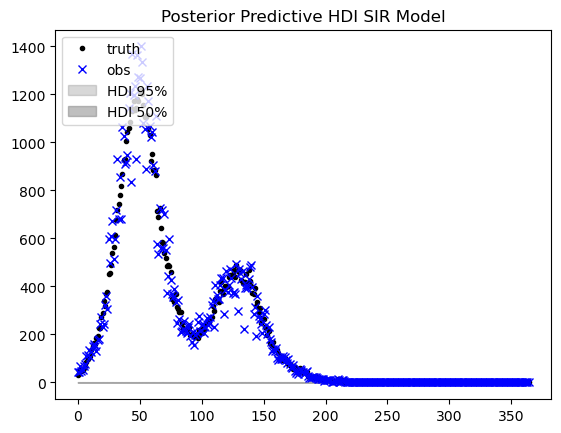

In [149]:
sir_model.calc_ppc()
sir_model.plot_ppc()
sir_model.calc_ppc_data()

### Transform RV
For a bounded random variable $X \in (a,b)$, define
$$
Y=\operatorname{logit}\left(\frac{X-a}{b-a}\right)
$$

so 
$$
X = a + \frac{b-a}{1 + e^{-Y}}
$$

### Figure out how the hell PyMC is calculating likelihoods

In [354]:
def halfcauchy(x,beta):
    if x < 0:
        raise ValueError("x must be positive")
    if beta < 0:
        raise ValueError("beta must be positive")
        
    return 2/(np.pi*beta*(1+(x/beta)**2))

def forward(x, a, b):
    u = (x - a)/(b-a)
    return np.log(u / (1 - u))

def backward(y, a, b):
    return a + (b-a)/(1 + np.exp(-y))


index_map = {
    'rt_0': 0,
    'rt_1': 1,
    'k': 2,
    'midpoint': 3,
    'I0': 4,
}

def check_one_bound(new_draw, var):
    index = index_map[var]
    if index == 4:
        return new_draw > 0
    else:
        return new_draw > prior[var]['lower'] and new_draw < prior[var]['upper']
    
def draw_sample_elemwise(draw, var, scales):
    index = index_map[var]
    
    scale = scales[index]
    
    bounds_good = False
    
    while(not bounds_good):
        val = norm(loc=draw[var], scale=scale).rvs(1)[0]
        bounds_good = check_one_bound(val, var)
    
    if index == 3 or index == 4:
        val = int(val)
    
    return val

def draw_sample_elemwise_nobound(draw, var, scale=2):
    index = index_map[var]
    val = norm(loc=draw[var], scale=scale).rvs(1)[0]
    
    return val

def sample_new(rt_0, rt_1, k, midpoint, I0, scale=[0.1, 0.1, 0.01, 2, 2]):
    
    bounds_good = False
    
    while(not bounds_good):
        new_draw = multivariate_normal(mean=np.array([rt_0, rt_1, k, midpoint, I0]), cov=np.diag(scale)).rvs(1)
        bounds_good = check_bounds(new_draw)
    
    return new_draw[0], new_draw[1], new_draw[2], int(new_draw[3]), int(new_draw[4])

def sample_new_midpoint(midpoint, scale=2):
    new_draw = norm(loc=midpoint, scale=scale).rvs(1)
    return int(new_draw[0])

def random_coin(p):
    unif = np.random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True

def log_random_coin(logp):
    unif = np.random.uniform(0,1)
    if np.log(unif)>=logp:
        return False
    else:
        return True

def integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0, n_t):
    t = np.arange(365)
    rt = rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint)))
    beta = rt / t_I
    S = np.array([S0])
    Ir = np.array([I0])
    R = np.array([0])
    i = np.array([0])
    for t in range(n_t):
        dSI = np.random.poisson(beta[t]*Ir[t]*S[t]/N)
        dIR = np.random.poisson(Ir[t]/t_I)

        S_new = np.clip(S[t]-dSI, 0, N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, N)
        R_new = np.clip(R[t]+dIR, 0, N)

        S = np.append(S, S_new)
        Ir = np.append(Ir, I_new)
        R = np.append(R, R_new)
        i = np.append(i, dSI)

    return S, Ir, R, i


def logprior_prob(rt_0, rt_1, k, midpoint, I0):
    p_rt_0 = uniform(loc=prior['rt_0']['lower'], scale=(prior['rt_0']['upper'] - prior['rt_0']['lower'])).logpdf(rt_0)
    p_rt_1 = uniform(loc=prior['rt_1']['lower'], scale=(prior['rt_1']['upper'] - prior['rt_1']['lower'])).logpdf(rt_1)
    p_k = uniform(loc=prior['k']['lower'], scale=(prior['k']['upper'] - prior['k']['lower'])).logpdf(k)
    p_midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).logpmf(midpoint)
    p_I0 = poisson(prior['I0']['mu']).logpmf(I0)
    
    prob = np.sum([p_rt_0, p_rt_1, p_k, p_midpoint, p_I0])
    
    return prob

def loglike_prob(i, data=data.i):
    # prob = multivariate_normal(mean=i[1:], cov=np.diag((1+0.2*i[1:])**2)).logpdf(data[1:])
    prob = norm(loc=i[1:], scale=np.abs(1+0.2*i[1:])).logpdf(data[1:])
    # prob = norm(loc=i[1:200], scale=np.abs(1+0.2*i[1:])).logpdf(data[1:200])
    prob = np.sum(prob)
    return prob

def tune(scale, acc_rate):
    """
    Tunes the scaling parameter for the proposal distribution
    according to the acceptance rate over the last tune_interval:

    Rate    Variance adaptation
    ----    -------------------
    <0.001        x 0.1
    <0.05         x 0.5
    <0.2          x 0.9
    >0.5          x 1.1
    >0.75         x 2
    >0.95         x 10

    """
    return scale * np.where(
        acc_rate < 0.001,
        # reduce by 90 percent
        0.1,
        np.where(
            acc_rate < 0.05,
            # reduce by 50 percent
            0.5,
            np.where(
                acc_rate < 0.2,
                # reduce by ten percent
                0.9,
                np.where(
                    acc_rate > 0.95,
                    # increase by factor of ten
                    10.0,
                    np.where(
                        acc_rate > 0.75,
                        # increase by double
                        2.0,
                        np.where(
                            acc_rate > 0.5,
                            # increase by ten percent
                            1.1,
                            # Do not change
                            1.0,
                        ),
                    ),
                ),
            ),
        ),
    )
    
    
def metropolis_hastings(burn_in, draws, tune_interval=100, sample_elemwise=False):
    # things to track
    i_list = []
    chain = []
    like_list = []
    prior_list = []
    accept_list = {
        'rt_0': [1],
        'rt_1': [1],
        'k': [1],
        'midpoint': [1],
        'I0': [1]
    }
    accept_prob_list = []
    scale_list = []
    
    # rt_0 = prior['rt_0']['dist'](loc=prior['rt_0']['lower'], scale=(prior['rt_0']['upper'] - prior['rt_0']['lower'])).rvs(1)[0]
    # rt_1 = uniform(loc=prior['rt_1']['lower'], scale=(prior['rt_1']['upper'] - prior['rt_1']['lower'])).rvs(1)[0]
    # k = uniform(loc=prior['k']['lower'], scale=(prior['k']['upper'] - prior['k']['lower'])).rvs(1)[0]
    # midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).rvs(1)[0]
    # I0 = poisson(prior['I0']['mu']).rvs(1)[0]
    
    rt_0 = data.rt_0
    rt_1 = data.rt_1
    k = data.k
    midpoint = randint(low=prior['midpoint']['lower'], high=prior['midpoint']['upper']).rvs(1)[0]
    I0 = data.I0
    
    S0 = N - I0
    
    current = {
        "rt_0": rt_0,
        "rt_1": rt_1,
        "k": k,
        "midpoint": midpoint,
        "I0": I0,
    }
    chain.append(current.copy())
    
    accept = 1
    scales = np.array([0.1, 0.1, 0.01, 2, 2])
    scale_list.append(scales)

    from tqdm import tqdm
    
    if sample_elemwise:
        for j in tqdm(range(int((burn_in+draws)/5))):
            if j > 0 and j*5 % tune_interval == 0:
                acc_rate = np.mean(np.array(list(accept_list.values())), axis=1)
                scales = tune(scales, acc_rate)
            
            params = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']
            np.random.shuffle(params)
                
            for param in params:
                
                if accept == 1:
                    _, _, _, i = integrate(t_I=t_I, N=N, S0=N - current['I0'], n_t=n_t, **current.copy())

                i_list.append(i)

                logprior = logprior_prob(**current)
                loglike = loglike_prob(i)
                curr_prob = logprior + loglike
                
                new_draw = current.copy()
                val = draw_sample_elemwise(new_draw, param, scales)
                new_draw[param] = val
                
                S0_new = N - new_draw['I0']
                
                _, _, _, i_new = integrate(t_I=t_I, N=N, S0=S0_new, n_t=n_t, **new_draw.copy())

                logprior_new = logprior_prob(**new_draw.copy())
                loglike_new = loglike_prob(i_new)
                move_prob = logprior_new + loglike_new

                logacceptance = np.minimum(move_prob - curr_prob, 0.)
                accept_prob_list.append(logacceptance)

                if log_random_coin(logacceptance):
                    current[param] = val
                    accept = 1
                    accept_list[param].append(accept)
                    like_list.append(loglike_new)
                    prior_list.append(logprior_new)
                else:
                    accept = 0
                    accept_list[param].append(accept)
                    like_list.append(loglike)
                    prior_list.append(logprior)
            
                chain.append(current.copy())
    
    else:
        for iter in tqdm(range(burn_in+draws)):

            if accept == 1:
                _, _, _, i = integrate(rt_0, rt_1, k, midpoint, I0, t_I, N, S0=N-I0, n_t=n_t)

            i_list.append(i)

            logprior = logprior_prob(rt_0, rt_1, k, midpoint, I0)
            loglike = loglike_prob(i)
            curr_prob = logprior + loglike

            rt_0_new, rt_1_new, k_new, midpoint_new, I0_new = sample_new(rt_0, rt_1, k, midpoint, I0)
            # midpoint_new = sample_new_midpoint(midpoint)
            S0 = N - I0_new
            _, _, _, i_new = integrate(rt_0_new, rt_1_new, k_new, midpoint_new, I0_new, t_I, N, S0, n_t)

            logprior_new = logprior_prob(rt_0_new, rt_1_new, k_new, midpoint_new, I0_new)
            loglike_new = loglike_prob(i_new)
            move_prob = logprior_new + loglike_new

            # print(f"proposed: {midpoint_new}, log prior: {prior_new}, like_new: {like_new}")

            logacceptance = np.minimum(move_prob - curr_prob, 0.)
            accept_prob_list.append(logacceptance)

            if log_random_coin(logacceptance):
                current = {
                    "rt_0": rt_0,
                    "rt_1": rt_1,
                    "k": k,
                    "midpoint": midpoint_new,
                    "I0": I0,
                }
                rt_0 = rt_0_new
                rt_1 = rt_1_new
                k = k_new
                midpoint = midpoint_new
                I0 = I0_new
                accept = 1
                accept_list.append(accept)
                like_list.append(loglike_new)
                prior_list.append(logprior_new)
            else:
                accept = 0
                accept_list.append(accept)
                like_list.append(loglike)
                prior_list.append(logprior)

            chain.append(current)

    return chain[burn_in:], chain[:burn_in], accept_list, accept_prob_list, np.array(i_list), like_list, prior_list, scale_list

In [ ]:
trace, burn_in, accept_list, accept_prob_list, i, like_list, prior_list, scale_list = metropolis_hastings(burn_in=1000, draws=5000, sample_elemwise=True)

In [36]:
import pymc as pm
import pytensor
import pytensor.tensor as pt

def compute_loglikelihood(i):
    t = np.arange(0, 365)
    coords = {'day':t}
    with pm.Model(coords=coords) as likelihood_sampler:
        normal = pm.MvNormal(
            "like_normal",
            mu=i[1:],
            cov=np.diag((1+0.2*i[1:])**2),
            dims="day"
        )
    return likelihood_sampler.compile_logp()({'like_normal': data.i[1:]})

In [37]:
compute_loglikelihood(i)

array(-20647803.79705628)

In [38]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.MvNormal(
        "like_normal",
        mu=i[1:],
        cov=np.diag((1+0.2*i[1:])**2),
        dims="day"
    )

In [39]:
pm.logp(normal, data.i[1:]).eval()

array(-20647803.79705628)

Things are consistent between PyMC and my janky code when using `pm.MvNormal`

In [40]:
def like_prob_univariate(i, data=data.i):
    prob = norm(loc=i[1:], scale=(1+0.2*i[1:])).logpdf(data[1:])
    return prob

In [41]:
np.sum(like_prob_univariate(i))

-20647803.79705623

In [42]:
t = np.arange(0, 365)
coords = {'day':t}
with pm.Model(coords=coords) as likelihood_sampler:
    normal = pm.Normal(
        "like_normal",
        mu=i[1:],
        sigma=np.abs(1+0.2*i[1:]),
        dims="day"
    )

In [43]:
np.sum(pm.logp(normal, data.i[1:]).eval())

-20647803.79705623